In [2]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/nasar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nasar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
fake=pd.read_csv('./data/Fake.csv')
real=pd.read_csv('./data/True.csv')

In [5]:
fake['label']='fake'
real['label']='real'

df = pd.concat([fake, real]).sample(frac=1).reset_index(drop=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [7]:
import re
import spacy
from nltk.corpus import stopwords
import string

In [8]:
# Load spacy model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords using nltk
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatization using spacy
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    return text


In [ ]:
df_sample = df.head(2000)

df_sample['processed_title'] = df_sample['title'].apply(preprocess_text)
df_sample['processed_text'] = df_sample['text'].apply(preprocess_text)
df_sample['processed_subject'] = df_sample['subject'].apply(preprocess_text)
df_sample['processed_date'] = df_sample['date'].astype(str).apply(preprocess_text)

processed_sample_df = df_sample[['processed_title', 'processed_text', 'processed_subject', 'processed_date', 'label']]

processed_sample_df.head()

/tmp/ipykernel_22056/2232442872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['processed_title'] = df_sample['title'].apply(preprocess_text)
/tmp/ipykernel_22056/2232442872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['processed_text'] = df_sample['text'].apply(preprocess_text)
/tmp/ipykernel_22056/2232442872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,processed_title,processed_text,processed_subject,processed_date,label
0,trump say thought fire russia probe special co...,bedminster nj reuter us president donald trump...,politicsnew,august,real
1,nra board member ted nugent encourage violent ...,stochastic terrorism term mean use mass commun...,news,may,fake
2,michigan militia group turn rightwe governor r...,general rule militia group side liberal anythi...,news,january,fake
3,iranian fear economic hardship united trump,ankara reuter us president donald trump harden...,worldnew,october,real
4,emotional trump endorsement former fbi asst di...,former fbi asst director james kallstrom endor...,government news,oct,fake


In [12]:
from nltk.tokenize import word_tokenize

# Tokenize processed columns in the sample dataframe
processed_sample_df['tokens_title'] = processed_sample_df['processed_title'].apply(word_tokenize)
processed_sample_df['tokens_text'] = processed_sample_df['processed_text'].apply(word_tokenize)
processed_sample_df['tokens_subject'] = processed_sample_df['processed_subject'].apply(word_tokenize)
processed_sample_df['tokens_date'] = processed_sample_df['processed_date'].apply(word_tokenize)

# Display tokenized sample
processed_sample_df[['tokens_title', 'tokens_text', 'tokens_subject', 'tokens_date', 'label']].head()

/tmp/ipykernel_22056/339991528.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_sample_df['tokens_title'] = processed_sample_df['processed_title'].apply(word_tokenize)
/tmp/ipykernel_22056/339991528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_sample_df['tokens_text'] = processed_sample_df['processed_text'].apply(word_tokenize)
/tmp/ipykernel_22056/339991528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,tokens_title,tokens_text,tokens_subject,tokens_date,label
0,"[trump, say, thought, fire, russia, probe, spe...","[bedminster, nj, reuter, us, president, donald...",[politicsnew],[august],real
1,"[nra, board, member, ted, nugent, encourage, v...","[stochastic, terrorism, term, mean, use, mass,...",[news],[may],fake
2,"[michigan, militia, group, turn, rightwe, gove...","[general, rule, militia, group, side, liberal,...",[news],[january],fake
3,"[iranian, fear, economic, hardship, united, tr...","[ankara, reuter, us, president, donald, trump,...",[worldnew],[october],real
4,"[emotional, trump, endorsement, former, fbi, a...","[former, fbi, asst, director, james, kallstrom...","[government, news]",[oct],fake


In [17]:
import pickle

# Join tokens back to string for vectorization
processed_sample_df['text_for_vectorizer'] = processed_sample_df['tokens_text'].apply(lambda tokens: ' '.join(tokens))

# Vectorize the text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_sample_df['text_for_vectorizer'])
y = processed_sample_df['label'].map({'fake': 0, 'real': 1})  # Encode labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(class_weight='balanced',max_iter=1000)
model.fit(X_train, y_train)

# Save vectorizer and model to disk
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Evaluate model
score = model.score(X_test, y_test)
print(f"Test Accuracy: {score:.4f}")

Test Accuracy: 0.9575


In [21]:
from sklearn.metrics import mean_squared_error, r2_score, f1_score

# Predict on test set
y_pred = model.predict(X_test)

# MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

# R2 Score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

MSE: 0.0425
R2 Score: 0.8283
F1 Score: 0.9534


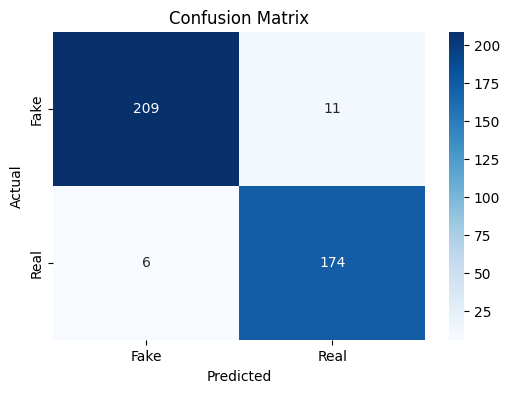

In [23]:
import seaborn as sns

# Generate and display the confusion matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()